In [1]:
from deltas import *
from training import *
import pandas as pd 

fleet = ['VQ-BGU', 'VQ-BDU']
y_cols = ['egtm']
meta_cols = ['reportts', 'acnum', 'pos']

In [2]:
bgu = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']).query('egtm > 0 and tat_peak >= -100 and egt_peak >= 0 and reportts > "2018-01-15"')
bdu = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts']).query('egtm > 0 and tat_peak >= -100 and egt_peak >= 0')

data_all = pd.concat([
    correct(bgu), 
    correct(bdu)
]).sort_values('reportts', ignore_index=True).drop(columns=['file_path', 'dep', 'arr'], errors="ignore")

data_all.shape

(3771, 219)

In [3]:
# acms_full = pd.read_csv(
#   './data/neo_takeoff_202403260034.csv', 
#   parse_dates=['reportts'], 
#   low_memory=False
# ).drop(columns=['processedts']).sort_values('reportts', ignore_index=True)

In [4]:
data = add_egt_delta_to_dataset(
  data_all.copy(), 
  fleet=fleet, 
  early=True, 
  interval=pd.to_timedelta('30 D'),
  x_param='n2a_peak_k', 
  y_param='egt_peak_k',
  bleed_param='prv'
)

In [5]:
bdu.groupby(['acnum', 'pos']).count()

reportts  egtm  file_path  fltdes   dep   arr    pf   wai   nai  \
acnum  pos                                                                    
VQ-BDU 1         777   777        777     777   777   777   777   777   777   
       2        1324  1324       1324    1324  1324  1324  1324  1324  1324   

             prv  ...  tol  tr   ttp   vb1   vb2  vorrc  vorv  votm  vsva  \
acnum  pos        ...                                                       
VQ-BDU 1     777  ...    0   0   703   777   777    777     0     0   777   
       2    1324  ...    0   0  1178  1324  1324   1324     0     0  1324   

             w14  
acnum  pos        
VQ-BDU 1     777  
       2    1324  

[2 rows x 206 columns]

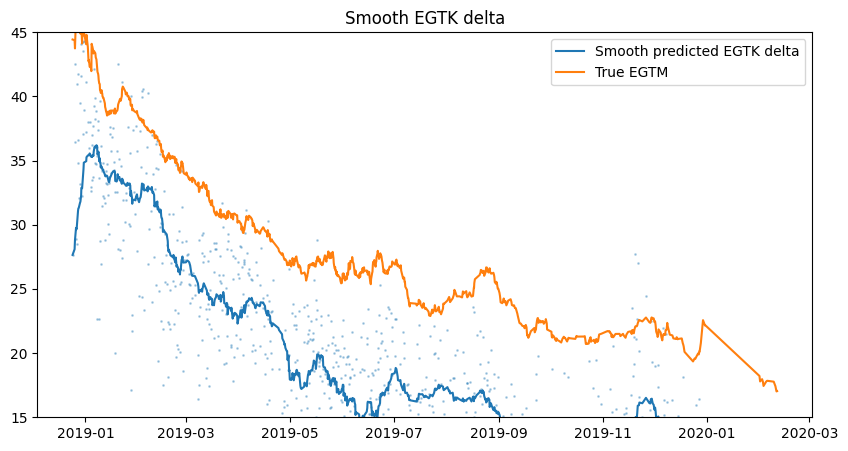

In [6]:
import matplotlib.pyplot as plt

sub = data.query('pos==1 and acnum=="VQ-BGU"')

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)

ax.plot(sub['reportts'], smooth(sub['egt_delta'], alpha=0.05))
ax.plot(sub['reportts'], sub['egtm'])
ax.scatter(sub['reportts'],  sub['egt_delta'], s=1, alpha=0.3)
ax.set_title('Smooth EGTK delta')
ax.set_ylim([15, 45])
ax.legend(['Smooth predicted EGTK delta', 'True EGTM'])

plt.show()

In [7]:
features_k = ['egt_delta_smooth', 'egt_peak_k', 'tat_peak', 'n1a_peak_k', 'alt', 'nfk', 'prv']

dataset = build_dataset(
  fleet,
  y_cols, 
  meta_cols, 
  features_k,
  n_back=12,
  data=data
)

In [8]:
from sklearn.linear_model import Ridge

def predict_boolean_ensemble(models: List[Ridge], X: pd.DataFrame, field='nai'):
  pred = pd.DataFrame(index=X.index.copy(), columns=['pred'])
  for val in [True, False]:
    index = (X[field] == val)
    pred.loc[index, 'pred'] = models[val].predict(X[index])
  return pred

def filter_split_by_bool_field(X: pd.DataFrame, y: pd.DataFrame, field: str, value: bool):
  return X[X[field] == value], y[X[field] == value]

def train_boolean_ensemble_model(X, y, field = 'nai'):
  print(">>>> ", X.shape)
  assert len(X) == len(y)
  train_i = int(len(X) * 50 / 100)
  X_train, y_train = X[0:train_i], y[0:train_i]
  X_test, y_test = X[train_i:], y[train_i:]

  ensemble = dict()
  ensemble[True] = Ridge()
  ensemble[False] = Ridge()

  for val in [True, False]:
    X_train_f, y_train_f = filter_split_by_bool_field(X_train, y_train, field, val)
    ensemble[val].fit(X_train_f, y_train_f)
  
  predicted_train = predict_boolean_ensemble(ensemble, X_train, field)

  predicted_test = predict_boolean_ensemble(ensemble, X_test, field)

  print(X_test.shape, predicted_test.shape)

  return get_metrics(y_test, predicted_test['pred']), ensemble, predicted_train, predicted_test, train_i, y_test

In [9]:
X = dataset.drop(columns=(meta_cols + y_cols))
y = dataset['egtm']

metrics, prv_ensemble, predicted_train, predicted_test, train_i, y_test = \
  train_boolean_ensemble_model(X, y, field='prv')

print(f'PRV ensemble: {metrics}')

>>>>  (3771, 91)
(1886, 91) (1886, 1)
PRV ensemble: {'rmse': 1.77748, 'mae': 1.40495, 'r2': 0.69212, 'mape': 0.06555}


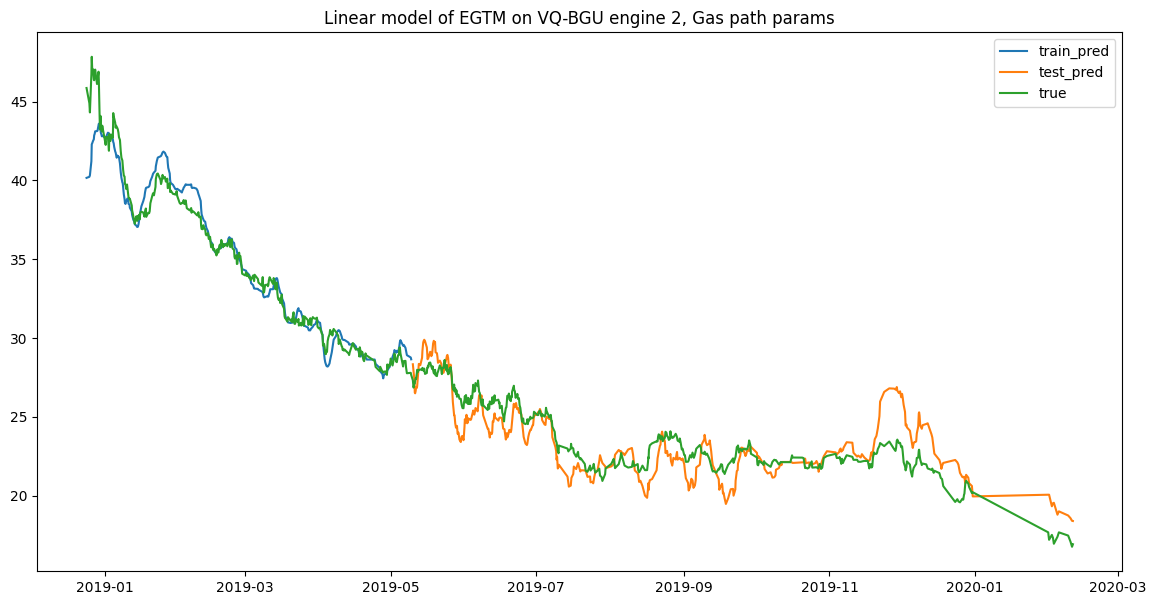

In [10]:
plot_predictions(data, 'VQ-BGU', 2, train_i, predicted_test, predicted_train, is_smooth=True, alpha=0.2)

### Evaluation Steps: 
0. Given ACMS data 
1. Apply theta corrections to data
2. Take earliest n cycles, train baselines for each engine
3. Calculate EGT Delta from baseline for each engine 
4. Smoothen EGT Delta and append it to ACMS data 
5. Predict EGT Maring using pre-trained ensemble model

In [11]:
from joblib import dump, load

# dump(prv_ensemble, 'models/prv_ensemble_1.joblib') 